In [1]:
import numpy as np
import pandas as pd
import numba
from scipy.misc import comb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#@numba.jit
def predMerge(t, M):
    '''
    input: t is a 1d-array of partition labels, shape is (n_record,)
           M is the similarity matrix
    output: best_t is the new partition which maximize the weighted average similarity between each pair of clusters
            best_ind is a pair of indexed for the merged clusters
    '''
    i,j = divmod(M.argmax(), M.shape[1])
    
    new_M = np.copy(M)
    new_t = np.copy(t)
    
    uni_t = np.unique(new_t)
    new_t[t==uni_t[j]] = uni_t[i]
    
    new_M[i,(i+1):] = (new_M[(i+1):,j].transpose() + new_M[i,(i+1):])/2.0
    new_M[:i,i] = (new_M[:i,j] + new_M[:i,i])/2.0
    
    new_M = np.delete(new_M,j,0)
    new_M = np.delete(new_M,j,1)
    
    return (new_t,new_M)

In [26]:
%timeit predMerge(t0,M0)

The slowest run took 11.18 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 4.3 ms per loop


In [3]:
@numba.jit
def label2mat(t):
    '''
    input: t is a 1d-array of partition labels, shape is (n_records,), e.g. array([1,1,2,3])
    output: m is a 2d-array adjacency matrix of shape (n_records,n_records)
    '''
    n = t.shape[0]
    m = np.eye(n)
    for i in range((n-1)):
        for j in range((i+1),n):
            if (t[j]==t[i]):
                m[i,j] = 1
    m += (m.transpose() - np.eye(n))
    return(m)

In [4]:
@numba.jit
def trueScore(t,y):
    '''
    input:
    output:
    '''
    M = label2mat(t)
    n = M.shape[0]
    return (1-np.sum((M-y)**2)/(n**2))

In [43]:
%timeit trueScore(t0,y_D)

10 loops, best of 3: 59.8 ms per loop


In [18]:
def createTree(t0,X,w,R):
    '''
    input: t0 is the initial partition of shape (n_record,)
           X is the 2-d array of record features, n_record*n_feature
           w is the weight of shape (n_feature,)
           R is the number of partitions in a sequence
    output: T is a sequence of  partitions
    '''
    M0 = X.dot(w0).reshape((n,n))
    M0 = np.triu(M0, k=1)
    
    T = [t0]

    for r in range(R):
        t,M1 = predMerge(T[r],M0)
        T.append(t)
        M0 = np.copy(M1)

    return T

In [8]:
%timeit T = createTree(t0,X,w0,577)

1 loops, best of 3: 1.09 s per loop


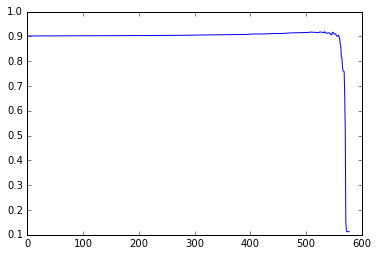

In [123]:
# plot score against clustering number
T = createTree(t0,X,np.array([0.6,0.2]),577)
s = [trueScore(x,y_D) for x in T]
n_t = np.array(range(len(s)))
plt.plot(n_t,np.array(s))

In [9]:
def trueMerge(t,new_t,y_D):
    '''
    input: 
    output:
    '''
    uni_t = np.unique(t)
    n_c = uni_t.shape[0]
    max_score = trueScore(new_t,y_D) # 60 ms
    best_t = np.copy(t)
    
    for i in range(n_c-1):
        for j in range((i+1),n_c):
            this_t = np.copy(t)
            this_t[t==uni_t[j]] = uni_t[i]
            this_score = trueScore(this_t,y_D) # 60 ms
            if (this_score>max_score):
                best_t = this_t
                break
    return best_t

In [124]:
def randomMerge(t,new_t,y_D):
    '''
    input:
    output:
    '''
    uni_t = np.unique(t)
    n_c = uni_t.shape[0]
    max_score = trueScore(new_t,y_D) # 60 ms
    best_t = np.copy(t)
    
    i = np.random.randint(n_c-1)
    j = np.random.randint((i+1),n_c)
    this_t = np.copy(t)
    this_t[t==uni_t[j]] = uni_t[i]
    this_score = trueScore(this_t,y_D) # 60 ms
    if (this_score>max_score):
        best_t = this_t
    return best_t

In [108]:
def updateW(w,true_t,new_t,X,h=0.5,alpha=0.1,n_run=10000):
    '''
    input:
    output:
    '''
    n = X.shape[0]
    T1 = label2mat(true_t).reshape((n,1))
    T2 = label2mat(new_t).reshape((n,1))
    gw_0 = np.mean(T1*X,0).reshape(w.shape)
    gw = np.mean(T2*X,0).reshape(w.shape)
    
    #print(np.transpose(gw_0).dot(w))
    #print(np.transpose(gw).dot(w))
    new_w = np.copy(w)
    r = 0
    while(((np.transpose(gw_0).dot(new_w)<np.transpose(gw).dot(new_w)+0.000005)|(np.transpose(gw).dot(new_w)>0.5))&(r<n_run)):
        new_w += (gw_0 - gw)*0.1
        r += 1
    return new_w  

In [137]:
def train_errorDriven(X,y,w0=np.array([0.7,0.3]),n_run=100,R=577):
    '''
    input: my_df the cleaned-up dataframe
           features is a list of features to be caculated
           n_run is the number of iterations
           R is the deepth of partition tree
           th is the converge threshold
    output: w0 is the best weight for similarity
    '''
    n = int(np.sqrt(X.shape[0]))
    y_D = y.reshape((n,n))
    t0 = np.array([i for i in range(y_D.shape[0])])
    #w0 = np.random.uniform(size=(X.shape[1],1))
    w0 = w0.reshape((X.shape[1],1))
    #T = []
    
    for i in range(n_run):
        print(i)
        w = np.copy(w0)
        print(w)
        M = X.dot(w).reshape(n,n)
        M = np.triu(M,k=1)
        t = np.copy(t0)
        for r in range(R):
            new_t,new_M = predMerge(t,M)
            print(r)
            #true_t = trueMerge(t,new_t,y_D)
            true_t = randomMerge(t,new_t,y_D)
            diff = np.sum((label2mat(new_t)-label2mat(true_t))**2)
            if (diff!=0):
                print(true_t[true_t!=new_t])
                print(new_t[true_t!=new_t])
                w0 = updateW(w,true_t,new_t,X,h=0.5)
                break
            #T.append(new_t)
            M = np.copy(new_M)
            t = np.copy(new_t)

    return w0.reshape((X.shape[1],))

In [126]:
# start training
train_df = pd.DataFrame.from_csv('../output/feature1_ziwei.csv')
n = int(np.sqrt(train_df.shape[0]))
X = train_df.ix[:,['n_coauthor','onegram_journal']].values
y = train_df['is_same'].values
y_D = y.reshape((n,n)) 
t0 = np.array([i for i in range(577)])
w0 = np.array([0.7,0.3])
M0 = X.dot(w0).reshape((n,n))
M0 = np.triu(M0, k=1)

In [138]:
w = train_errorDriven(X,y,w0)

0
[[ 0.7]
 [ 0.3]]
0
[31]
[21]
1
[[ 0.69399271]
 [ 0.29399271]]
0
[31]
[21]
2
[[ 0.68798543]
 [ 0.28798543]]
0
[31]
[21]
3
[[ 0.68197814]
 [ 0.28197814]]
0
[31]
[21]
4
[[ 0.67597085]
 [ 0.27597085]]
0
[31]
[21]
5
[[ 0.66996357]
 [ 0.26996357]]
0
[31]
[21]
6
[[ 0.66395628]
 [ 0.26395628]]
0
[31]
[21]
7
[[ 0.65794899]
 [ 0.25794899]]
0
[31]
[21]
8
[[ 0.65194171]
 [ 0.25194171]]
0
[31]
[21]
9
[[ 0.64593442]
 [ 0.24593442]]
0
[31]
[21]
10
[[ 0.63992713]
 [ 0.23992713]]
0
[31]
[21]
11
[[ 0.63391984]
 [ 0.23391984]]
0
[31]
[21]
12
[[ 0.62791256]
 [ 0.22791256]]
0
[31]
[21]
13
[[ 0.62190527]
 [ 0.22190527]]
0
[31]
[21]
14
[[ 0.61589798]
 [ 0.21589798]]
0
[31]
[21]
15
[[ 0.6098907]
 [ 0.2098907]]
0
[31]
[21]
16
[[ 0.60388341]
 [ 0.20388341]]
0
[31]
[21]
17
[[ 0.59787612]
 [ 0.19787612]]
0
[31]
[21]
18
[[ 0.59186884]
 [ 0.19186884]]
0
[31]
[21]
19
[[ 0.58586155]
 [ 0.18586155]]
0
[31]
[21]
20
[[ 0.57985426]
 [ 0.17985426]]
0
[31]
[21]
21
[[ 0.57384698]
 [ 0.17384698]]
0
[31]
[21]
22
[[ 0.567839

In [131]:
w

array([ 0.09927132, -0.00036434])